# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [1]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [2]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/"+name+"/history?period1="+str(init)+"&period2="+str(end)+"&interval=1d&filter=history&frequency=1d"
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [3]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-07-2018', 'end' : '31-08-2018'},
                  {'init' : '01-04-2018', 'end' : '30-06-2018'},
                  {'init' : '01-01-2018', 'end' : '31-03-2018'},
                  {'init' : '01-10-2017', 'end' : '31-12-2017'},
                  {'init' : '01-07-2017', 'end' : '30-09-2017'},
                  {'init' : '01-04-2017', 'end' : '30-06-2017'},
                  {'init' : '01-01-2017', 'end' : '31-03-2017'}]


stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [4]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [16]:
stock_prices_pd.tail()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2018-07-24,18.97,45.36,28.01,19.66,51.31,22.30,10.62,43.56,25.20,16.92
2018-07-25,18.90,46.79,28.70,19.96,51.75,20.05,10.96,43.30,25.41,16.57
2018-07-26,19.89,46.05,27.71,19.41,52.78,19.76,10.77,42.40,24.70,16.01
2018-07-26,19.89,46.05,27.71,19.41,52.78,19.76,10.77,42.40,24.70,16.01
2018-07-27,20.03,46.06,27.70,19.70,53.45,NaN,10.75,42.66,24.83,16.02


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [7]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [8]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'Cardano' : 'cardano',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'IOTA' : 'iota',
              'EOS' : 'eos',
              'tether' : 'tether',
              'TRON' : 'tron',
              'dash' : 'dash'}

date_interval = {'init': '2017-01-01', 'end' : '2018-07-31' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [9]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd.tail()

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2018-07-22,7418.49,459.66,788.67,83.16,0.449311,0.170277,33.28,0.283534,128.72,7.90,0.981990,0.999843,0.035123,250.58
2018-07-23,7711.11,450.85,784.39,82.43,0.445276,0.164028,32.19,0.284384,133.57,7.97,0.933892,0.997496,0.034061,241.47
2018-07-24,8424.27,479.37,869.47,89.29,0.457623,0.173172,34.05,0.301456,147.40,8.60,0.984575,0.996505,0.038107,254.18
2018-07-25,8181.39,472.49,831.46,86.28,0.459829,0.172731,34.18,0.331706,142.74,8.51,0.986593,0.998791,0.037122,246.94
2018-07-26,7951.58,464.04,806.18,84.03,0.449920,0.164765,33.24,0.309552,136.81,8.32,1.010000,0.997951,0.035996,241.90


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

According to P. Morettin, the relative variance or the *simple liquidity return* $R_t$ of an asset is given by:

$$Rt = \frac{P_t - P_{t-1}}{P_{t-1}}$$


As $R_t$ is defined as the expected return of an asset, generally expressed as a percent value, $r_t$ however is defined as the *return rate* of an asset, given by:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Therefore, a simple return $R_t$ is obtained by: 

$$ R_t = {e^{r_t}} - 1 $$


The first term presented above $R_t$, is pretended to be used when the optimization takes place, while $r_t$ is the termo to be predicted with a GARCH model.

In [10]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

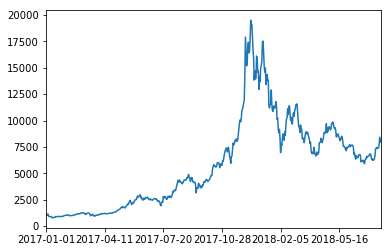

In [18]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

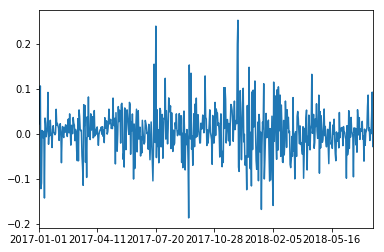

In [19]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

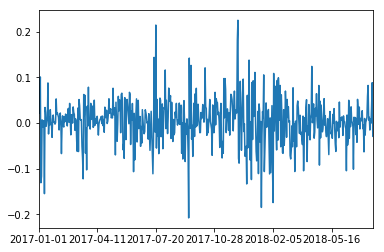

In [20]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

In [21]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,NaN,0.026798,-0.001612,0.14889,NaN,NaN,0.0,NaN,0.051647


In [22]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,NaN,0.026445,-0.001614,0.138797,NaN,NaN,0.0,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

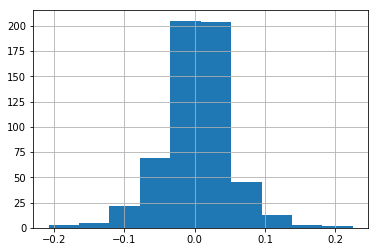

In [23]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [100]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
# remmoving duplicated indexes
percent_stocks_returns = percent_stocks_returns[~percent_stocks_returns.index.duplicated(keep='first')]
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
# remmoving duplicated indexes
percent_cripto_returns = percent_cripto_returns[~percent_cripto_returns.index.duplicated(keep='first')]
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccurr_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
# remmoving duplicated indexes
percent_returns_pd = percent_returns_pd[~percent_returns_pd.index.duplicated(keep='first')]
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: Some experts stand of the hyphothesis there is a weak negative correlation between criptocurrencies returns and stock market assets returns regarding FEAR index cotation, it means when there exists hihgher expeculation and fear in markets such as criptocurrencies, the subjective risk is transferred to stocked market.

It is showed in the heat map below with negative (although unexisting sometimes) correlation between the majority of cryptocurrencies and stocks.

In order to appreciate such phenomena, a heatmap showing correlations between all the assets considered is calculated.

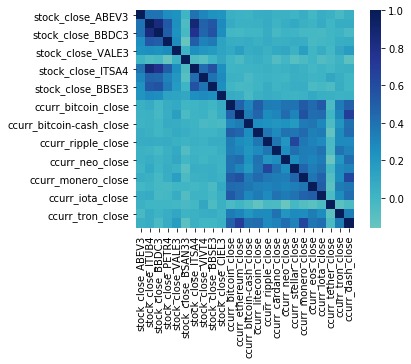

In [25]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering recomendations done by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [28]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 3, o_range = 0, q_range = 3, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'model': am, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


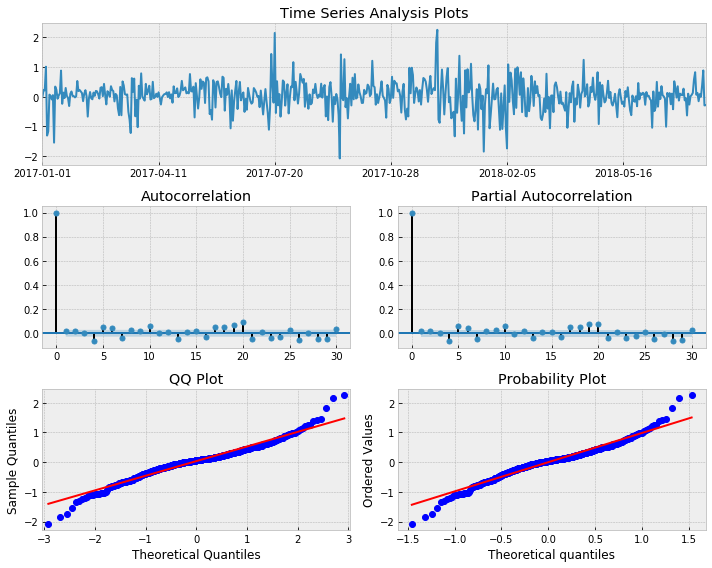

In [29]:
tsplot(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), lags = 30)

In [30]:
am = arch_model(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), mean='AR',p=7, o=0, q=7, dist = 'StudentsT')
res = am.fit(update_freq=5, disp='off')
res

                              AR - GARCH Model Results                              
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                              AR   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:               -339.622
Distribution:      Standardized Student's t   AIC:                           713.244
Method:                  Maximum Likelihood   BIC:                           787.179
                                              No. Observations:                  572
Date:                      Fri, Jul 27 2018   Df Residuals:                      555
Time:                              14:04:22   Df Model:                           17
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Cons

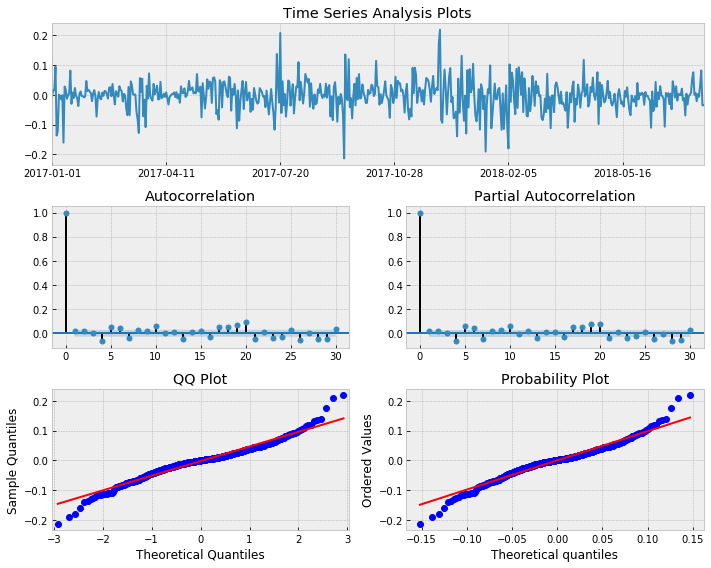

In [34]:
model_sample = fit_garch(ccurr_return_rates['ccurr_bitcoin_close'])
res = model_sample['model'].fit(update_freq=5, disp='off')
print(res)
tsplot(res.resid, lags = 30)


** Predicting the returns **

In [33]:
# Testing
test_returned = ccurr_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
h.1,0.004045,0.003822,0.0,0.006162,-0.010336,0.0,0.020073,0.001896,0.003072,0.0,-0.000013,-0.000688,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [34]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
h.1,0.004054,0.00383,0.0,0.006181,-0.010283,0.0,0.020276,0.001897,0.003077,0.0,-0.000013,-0.000688,0.0,0.014791


## Drawing Markowitz efficient frontier


Different from other proposals, this method will take advantage of the already simulated portafolios, trying to reach for the maximum return at each fixed risk value.

For this, it is supposed that the portfolio with the maximum return and te portafolio with the minimal risk belong to the Markowitz efficient frontier, furthermore these ones may allow us to determine the interval of risk values within the quoted frontier. 

### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [35]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == max(df['return'])]
    min_risk = df.loc[df['risk'] == min(df['risk'])]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### From the portfolios within Markowitz efficient frontier, Ratio Sharpe is the measure that will allow to pick the best one.

According to (EAFIT reference), the most known investement startegies are:

** The equal wiehgt strategy:** Is one of the most used strategy in portfolio diversification due its simplicity in implementation and understading. It simply weights every stock in a portfolio equally.

** Minimum variance strategy:** Based on Markoweitz portfolio optimizatoin model, from the optimizied portfolios set, the portafolio with the minimum value of variance is selected.

** Mean variance straegy:** Once the Markowitz efficient frontier is calculated, Ratio of Sharpe will lead to significant clues about what portfolio may be the best one when the investor does not have a clear idea about the level of risk he would tolerate.

As sawn since the beginning of this work, the model presented in this work includes the last two.

Once the Markowitz frotnier is drawn, an investor is capable to pick the risk he will tolerate considering the probable return the portfolio might offer. But in many cases, if not the most, evaluate in which level of risk is desired to operate could result difficult to do.

Therefore, the ratio of sharpe is introduced as an helpful criterion to overcome such difficulties.  

This metric considers a free-risk asset in order to involve cost of opportunity (similar to ROI value).



$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma} $$

$$ Where \ \sigma = \sqrt{Variance(𝑟_𝑝 − 𝑟_𝑓)} ; if \ 𝑟_𝑓 \ is \ risk-free, \ then: 𝜎 = 𝜎_𝑝 $$

Finally 

$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma_p} $$



Further work could be leverage towards testing a modified Ratio of Sharpe considering VaR instead of the portfolio variance. This remains out of the scope of this work due it was demostrated that using either the normal Ratio of Shape or the modified Ratio of Shape, does not represent any significant gain in deveolping markets such as the Colombian one where the volatility is higher. This scenario is different in already developed markets such as the american where using VaR instead of variance does delivers siginificant improvements, therefore testing how this modified version of such ratio works in the Brazilian market, is a future work.

For the sake of simplicity it is assumed that Brazilian market and Colombian market are more similar to each other in terms of volatility compared with the similarity between American and Brazilian market in the same context.


$$ Modified \ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{𝑉𝑎𝑅} $$


In [36]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [37]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 368 end: 398


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

ccurr.. init: 368 end: 398


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 368 end: 398


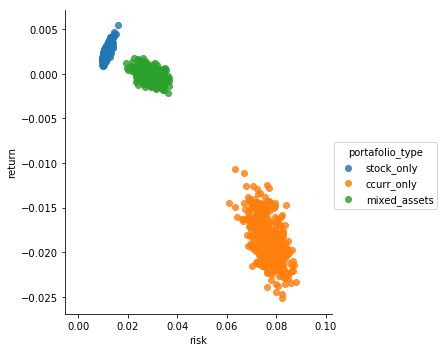

In [38]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

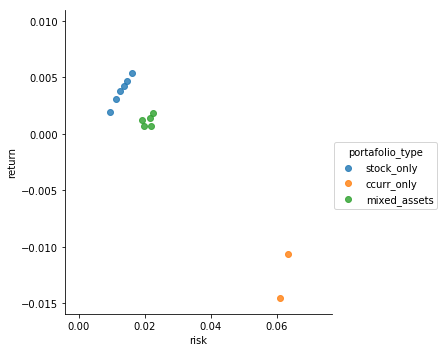

In [39]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [40]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
144,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",144,0.001896,0.009426,"[0.151999218882, 0.0928268920004, 0.0089481466...",stock_only
23,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",23,0.003105,0.011336,"[0.131970841918, 0.177276266498, 0.01319779082...",stock_only
315,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",315,0.003786,0.012414,"[0.170620482919, 0.138927299715, 0.09067395358...",stock_only
192,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",192,0.004209,0.013689,"[0.0616266348394, 0.174955054719, 0.0809234729...",stock_only
169,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",169,0.004678,0.014621,"[0.00990797485011, 0.113484834453, 0.248460223...",stock_only
397,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",397,0.005429,0.016071,"[0.0127922477957, 0.187415450582, 0.1761026919...",stock_only


*** Ratio of Sharpe ***

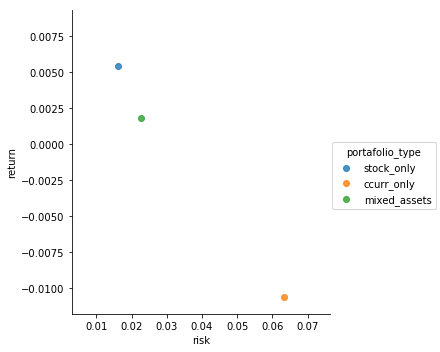

In [41]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Optimization with Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [42]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-2
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        return (return_portafolio / std_portafolio,) 
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return top10,pop, log, stats


############ Outputs processing ##############

def get_portafolio_stats(df_input, resource_optimal_distr):    
    average_close_portafolio = df_input.mean()
    cov_portafolio = df_input.cov()
    optimal_distr = resource_optimal_distr
    optimal_percentuals = np.divide(optimal_distr, sum(optimal_distr))
    return_in_percent = average_close_portafolio.dot(optimal_percentuals)
    risk_in_percent = cov_portafolio.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, resource_optimal_distr


## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [43]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    
    # Stock only
    top10_stock, pop_stock, log_stock, stas_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_stocks_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    top10_ccurr, pop_ccurr, log_ccurr, stas_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_cripto_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    top10, pop, log, stas = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_returns_pd[tail - (lag + window_time): tail - lag], pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output, df_ga_ccur_output, df_ga_output

In [44]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, True)

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

gen	nevals	avg     	std     	min      	max     
0  	1000  	0.224156	0.043656	0.0455594	0.324493
1  	578   	0.25706 	0.0432595	-0.09956 	0.357015
2  	621   	0.278843	0.0420275	-0.0467511	0.358412
3  	612   	0.298407	0.0374027	0.00322991	0.367054
4  	592   	0.310591	0.0418671	0.0106591 	0.37202 
5  	588   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	617   	0.331637	0.0451301	0.00959212	0.372626
7  	598   	0.338474	0.0476486	0.0141249 	0.372732
8  	600   	0.342042	0.0551053	-0.232745 	0.373458
9  	593   	0.342468	0.0547939	0.0400066 	0.374885
10 	594   	0.34649 	0.0540719	-0.03711  	0.375151
11 	615   	0.349724	0.0523458	-0.0547551	0.375636
12 	610   	0.347241	0.0572279	0.00689703	0.375636
13 	610   	nan     	nan      	nan       	nan     
14 	575   	nan     	nan      	nan       	nan     
15 	559   	nan     	nan      	nan       	nan     
16 	583   	nan     	nan      	nan       	nan     
17 	593   	nan     	nan      	nan       	nan     
18 	603   	nan     	nan      	nan       	nan     
19 	598   	nan     	nan      	nan       	nan     
20 	599   	nan     	nan      	nan       	nan     
21 	621   	nan     	nan      	nan       	nan     
22 	596   	nan     	nan      	nan       	nan     
23 	603   	0.353376	0.0632713	0.00210672	0.378838
24 	573   	0.347527	0.0738609	-0.2447   	0.378838
25 	609   	0.351561	0.0670426	-0.069337 	0.378838


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg      	std     	min      	max      
0  	1000  	-0.242737	0.026079	-0.320275	-0.150406
1  	625   	-0.219748	0.0259097	-0.329461	-0.132835
2  	599   	-0.19953 	0.0279642	-0.314917	-0.0888511
3  	591   	-0.180668	0.0336726	-0.330063	-0.0251217
4  	592   	-0.163015	0.0376319	-0.328917	-0.0141381
5  	598   	-0.143752	0.0413626	-0.327885	0.0264121 
6  	589   	-0.124446	0.0488208	-0.355872	0.0560686 
7  	590   	-0.108469	0.0569508	-0.359977	0.0607165 
8  	560   	-0.084146	0.0625775	-0.330933	0.0710382 
9  	585   	-0.0653729	0.0719547	-0.359174	0.0854027 
10 	590   	-0.0458566	0.0791057	-0.342581	0.0872245 
11 	618   	-0.0332624	0.0894455	-0.348217	0.0889702 
12 	628   	-0.0176077	0.0985509	-0.346646	0.0897808 
13 	560   	0.0035002 	0.0986466	-0.354219	0.0897808 
14 	615   	0.0140497 	0.111143 	-0.327879	0.0897808 
15 	582   	0.0230476 	0.114802 	-0.378083	0.0897808 
16 	604   	0.0250046 	0.11895  	-0.364724	0.0897808 
17 	587   	0.030132  	0.119303 	-0.354727	0.0897808 
18 	577 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


26 	612   	nan       	nan      	nan      	nan       
27 	589   	nan       	nan      	nan      	nan       
28 	606   	0.0339302 	0.118457 	-0.346833	0.0897808 
29 	597   	nan       	nan      	nan      	nan       
30 	584   	nan       	nan      	nan      	nan       
31 	579   	nan       	nan      	nan      	nan       
32 	596   	0.0344056 	0.11729  	-0.364724	0.0897808 
33 	604   	nan       	nan      	nan      	nan       
34 	600   	nan       	nan      	nan      	nan       
35 	621   	nan       	nan      	nan      	nan       
36 	632   	nan       	nan      	nan      	nan       
37 	563   	nan       	nan      	nan      	nan       
38 	591   	nan       	nan      	nan      	nan       
39 	607   	nan       	nan      	nan      	nan       
40 	561   	nan       	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg        	std      	min       	max      
0  	1000  	-0.00242592	0.0227448	-0.0711285	0.0839938
1  	602   	0.0179203  	0.0241416	-0.0774002	0.131617 
2  	595   	0.0378568  	0.0274424	-0.0913828	0.168181 
3  	633   	0.0588893  	0.0335925	-0.0553714	0.220837 
4  	645   	0.0809054  	0.0415536	-0.0856763	0.251919 
5  	585   	0.104241   	0.0477095	-0.0590371	0.282774 
6  	608   	0.127086   	0.0568507	-0.103904 	0.307167 
7  	585   	0.151078   	0.0649744	-0.0804443	0.382086 
8  	627   	0.177915   	0.0754615	-0.0954845	0.382086 
9  	588   	0.201586   	0.0835589	-0.0809836	0.382086 
10 	638   	0.226487   	0.0934585	-0.122072 	0.387672 
11 	578   	0.245802   	0.0996148	-0.0821152	0.389734 
12 	596   	0.26307    	0.107843 	-0.123726 	0.389734 
13 	588   	0.276849   	0.11746  	-0.123853 	0.39871  
14 	610   	0.291747   	0.124226 	-0.0668696	0.400851 
15 	586   	0.294668   	0.13589  	-0.0825521	0.403366 
16 	613   	0.3069     	0.135972 	-0.105689 	0.407322 
17 	549   	0.320612   	0.134

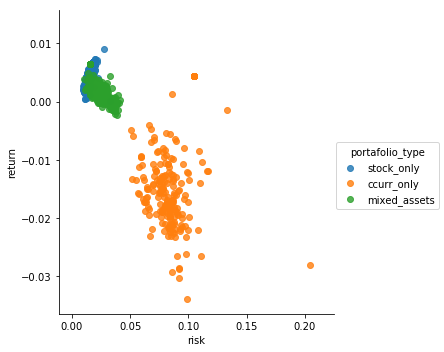

In [45]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

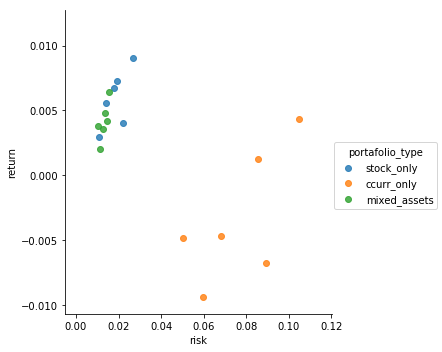

In [47]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
pre_fixed_time_window = 5
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [48]:
tempos = dict()
num_iterations = 10

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 30, 30

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

for i in range(1,num_iterations+1):
    print((num_iterations-i)*lag_step_size, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

270 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std     	min     	max      
0  	1000  	-0.0329223	0.044322	-0.17934	0.0969328
1  	580   	0.00456807	0.0398839	-0.21469	0.115384 
2  	610   	0.0352057 	0.0356165	-0.169703	0.131402 
3  	638   	0.0574736 	0.0357591	-0.264242	0.131402 
4  	620   	0.0728075 	0.0384609	-0.219893	0.131402 
5  	578   	0.0814099 	0.0429579	-0.22474 	0.133193 
6  	593   	0.089204  	0.0441935	-0.169924	0.133193 
7  	597   	0.0913529 	0.057328 	-0.293403	0.133193 
8  	579   	0.0952586 	0.0583233	-0.260851	0.133193 
9  	633   	0.0988161 	0.0609106	-0.263202	0.133327 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


10 	611   	nan       	nan      	nan      	nan      
11 	581   	nan       	nan      	nan      	nan      
12 	603   	nan       	nan      	nan      	nan      
13 	618   	nan       	nan      	nan      	nan      
14 	591   	nan       	nan      	nan      	nan      
15 	569   	nan       	nan      	nan      	nan      
16 	623   	nan       	nan      	nan      	nan      
17 	608   	0.10474   	0.0740393	-0.310056	0.133482 
18 	643   	0.103272  	0.0751381	-0.285209	0.133517 
19 	596   	0.104385  	0.0717973	-0.300961	0.133517 
20 	599   	0.10274   	0.0753051	-0.251032	0.133517 
21 	628   	0.101754  	0.0775541	-0.300961	0.133517 
22 	604   	nan       	nan      	nan      	nan      
23 	596   	nan       	nan      	nan      	nan      
24 	579   	nan       	nan      	nan      	nan      
25 	607   	0.102901  	0.0767395	-0.310056	0.133517 
26 	618   	0.106525  	0.0685225	-0.254902	0.133517 
27 	600   	nan       	nan      	nan      	nan      
28 	625   	0.102888  	0.0751596	-0.285209	0.133517 
29 	549   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWa

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.170285	0.0422409	0.0569192	0.362979
1  	611   	0.205754	0.0509758	0.040621 	0.447923
2  	542   	0.244077	0.0589406	0.0198503	0.474084
3  	587   	0.282007	0.0652426	-0.0197853	0.454313
4  	594   	0.319429	0.0717103	-0.0584185	0.478345
5  	582   	0.351151	0.0813902	-0.0436082	0.508377
6  	597   	0.369675	0.0893535	-0.0571448	0.544406
7  	601   	0.397066	0.0895468	-0.0579943	0.599549
8  	582   	0.410013	0.102527 	-0.0153835	0.600301
9  	645   	0.430391	0.114256 	-0.0529202	0.60036 
10 	630   	0.436481	0.144173 	-0.0485388	0.608166
11 	615   	0.465696	0.147579 	-0.0760415	0.608166
12 	599   	nan     	nan      	nan       	nan     
13 	591   	0.502609	0.157851 	-0.0738976	0.60872 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars



14 	597   	nan     	nan      	nan       	nan     
15 	613   	nan     	nan      	nan       	nan     
16 	548   	nan     	nan      	nan       	nan     
17 	589   	nan     	nan      	nan       	nan     
18 	605   	nan     	nan      	nan       	nan     
19 	583   	nan     	nan      	nan       	nan     
20 	601   	nan     	nan      	nan       	nan     
21 	595   	nan     	nan      	nan       	nan     
22 	565   	nan     	nan      	nan       	nan     
23 	598   	nan     	nan      	nan       	nan     
24 	562   	nan     	nan      	nan       	nan     
25 	617   	nan     	nan      	nan       	nan     
26 	568   	nan     	nan      	nan       	nan     
27 	624   	nan     	nan      	nan       	nan     
28 	589   	nan     	nan      	nan       	nan     
29 	586   	nan     	nan      	nan       	nan     
30 	611   	nan     	nan      	nan       	nan     
31 	629   	nan     	nan      	nan       	nan     
32 	597   	nan     	nan      	nan       	nan     
33 	562   	0.530077	0.181748 	-0.064301 	0.61516 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_sc

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg      	std     	min       	max     
0  	1000  	0.0347058	0.030546	-0.0930009	0.149607
1  	619   	0.0574629	0.0293755	-0.102657 	0.22161 
2  	594   	0.0775512	0.0299045	-0.113554 	0.207508
3  	615   	0.0961787	0.0345467	-0.112945 	0.232261
4  	593   	0.114751 	0.0444509	-0.119707 	0.260811
5  	625   	0.133976 	0.0528635	-0.150491 	0.281623
6  	582   	0.159534 	0.0532241	-0.0749167	0.281759
7  	586   	0.181292 	0.0604776	-0.145213 	0.316688
8  	598   	0.195454 	0.0742718	-0.155165 	0.302801
9  	620   	0.208935 	0.0763716	-0.154531 	0.318101
10 	599   	0.221317 	0.0846083	-0.153494 	0.328682
11 	611   	0.232971 	0.0905958	-0.212891 	0.328682
12 	580   	0.242194 	0.0968927	-0.194217 	0.33245 
13 	599   	0.253826 	0.100008 	-0.220175 	0.332767
14 	665   	0.256753 	0.102848 	-0.144207 	0.335874
15 	580   	0.265011 	0.10702  	-0.173677 	0.338512
16 	560   	0.273301 	0.106693 	-0.141712 	0.341739
17 	591   	0.276219 	0.110061 	-0.181206 	0.343148
18 	591   	0.279715 	0.108836 	-0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.254632	0.0443648	0.127456	0.462112
1  	612   	0.290223	0.0476117	0.0249672	0.621519
2  	606   	0.317027	0.0541226	0.0564451	0.621519
3  	591   	0.348541	0.0583338	0.043199 	0.621519
4  	597   	nan     	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


5  	585   	0.398689	0.0765884	0.0312991	0.621519
6  	613   	0.425819	0.0803418	0.0440008	0.621519
7  	596   	0.447311	0.0959309	-0.0711778	0.621519
8  	577   	0.472084	0.0958084	0.0169655 	0.640851
9  	601   	0.483496	0.119668 	-0.11717  	0.637727
10 	573   	nan     	nan      	nan       	nan     
11 	596   	nan     	nan      	nan       	nan     
12 	644   	nan     	nan      	nan       	nan     
13 	597   	0.547958	0.150338 	-0.11717  	0.645188
14 	584   	0.545762	0.162363 	-0.11717  	0.645188
15 	604   	0.553263	0.158018 	-0.110196 	0.645259
16 	615   	0.560183	0.158145 	-0.116631 	0.649919
17 	640   	0.563367	0.161477 	-0.11717  	0.649919
18 	561   	0.567335	0.160369 	-0.0603332	0.649919
19 	577   	0.568983	0.158692 	-0.0123581	0.649919
20 	585   	0.56147 	0.169527 	-0.0457822	0.655079
21 	574   	0.574726	0.15973  	-0.0597196	0.655079
22 	578   	nan     	nan      	nan       	nan     
23 	567   	nan     	nan      	nan       	nan     
24 	613   	nan     	nan      	nan       	nan     
25

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg     	std      	min       	max     
0  	1000  	0.110287	0.0351806	-0.0164927	0.208673
1  	600   	0.138939	0.0331795	-0.0133721	0.274492
2  	620   	0.161587	0.0347875	-0.0445598	0.320875
3  	600   	0.183107	0.0378618	-0.0287836	0.320875
4  	652   	0.19887 	0.0435974	-0.0515989	0.320875
5  	586   	0.216826	0.0455124	-0.0581748	0.347737
6  	597   	0.227823	0.0573762	-0.0513507	0.347737
7  	618   	0.241739	0.0609412	-0.0661946	0.347737
8  	580   	0.25196 	0.0686979	-0.0778302	0.361484
9  	609   	0.26257 	0.0707859	-0.0810405	0.348009
10 	561   	0.274307	0.0778997	-0.0252517	0.367915
11 	618   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	593   	nan     	nan      	nan       	nan     
13 	631   	nan     	nan      	nan       	nan     
14 	618   	nan     	nan      	nan       	nan     
15 	589   	nan     	nan      	nan       	nan     
16 	597   	nan     	nan      	nan       	nan     
17 	628   	nan     	nan      	nan       	nan     
18 	570   	0.320759	0.100829 	-0.0412385	0.370614
19 	630   	0.313286	0.110676 	-0.0845161	0.370628
20 	607   	0.316708	0.111603 	-0.0829231	0.370628
21 	607   	0.320039	0.106033 	-0.0444288	0.370628
22 	624   	0.322663	0.104369 	-0.0842424	0.370628
23 	608   	nan     	nan      	nan       	nan     
24 	592   	nan     	nan      	nan       	nan     
25 	592   	0.316292	0.11188  	-0.0801803	0.370628
26 	612   	0.322671	0.106143 	-0.0842424	0.370628
27 	607   	0.316989	0.110098 	-0.0803096	0.370628
28 	596   	nan     	nan      	nan       	nan     
29 	611   	0.316706	0.111557 	-0.0829231	0.370628
30 	612   	nan     	nan      	nan       	nan     
31 	622   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_sc

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg     	std      	min       	max     
0  	1000  	0.022468	0.0353773	-0.0757029	0.130958
1  	585   	0.0523173	0.0368473	-0.116395 	0.183075
2  	609   	0.0779276	0.0366104	-0.092698 	0.210017
3  	580   	0.0995697	0.0448394	-0.137286 	0.241234
4  	611   	0.120108 	0.0486333	-0.242901 	0.274019
5  	619   	0.140077 	0.0528451	-0.159312 	0.28773 
6  	598   	0.160943 	0.0563172	-0.124787 	0.28773 
7  	570   	0.175572 	0.0698458	-0.175752 	0.314592
8  	574   	0.197498 	0.0702672	-0.238146 	0.314592
9  	543   	0.215031 	0.0775088	-0.129447 	0.314592
10 	616   	0.230626 	0.0819134	-0.168065 	0.345211
11 	619   	0.239064 	0.0918307	-0.185056 	0.345211
12 	598   	0.250507 	0.0958279	-0.124188 	0.350163
13 	599   	0.256582 	0.103594 	-0.203253 	0.357134
14 	591   	0.263115 	0.110178 	-0.207131 	0.357134
15 	622   	0.276511 	0.105937 	-0.104432 	0.360352
16 	603   	0.284388 	0.108963 	-0.0984717	0.362213
17 	603   	0.285513 	0.117212 	-0.148209 	0.364673
18 	593   	0.287627 	0.124559 	-0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.158632	0.0481762	0.0051995	0.314604
1  	642   	0.196032	0.047657 	-0.0420307	0.336059
2  	597   	0.231112	0.0422995	0.0237195 	0.381779
3  	576   	0.257069	0.0460244	-0.0921275	0.365293
4  	569   	0.279364	0.0509732	-0.100792 	0.382086
5  	605   	0.29907 	0.0489176	-0.129857 	0.382086
6  	584   	0.314176	0.0555742	-0.0402949	0.383413
7  	592   	0.320529	0.0682975	-0.0497521	0.388393
8  	581   	0.334166	0.0654858	-0.00440071	0.397321
9  	626   	0.339799	0.0733672	-0.129857  	0.393161
10 	597   	0.343554	0.0778007	-0.0845692 	0.399115
11 	622   	0.345222	0.0809069	-0.0437941 	0.399115
12 	588   	nan     	nan      	nan        	nan     
13 	577   	nan     	nan      	nan        	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


14 	626   	nan     	nan      	nan        	nan     
15 	597   	0.354338	0.0912219	-0.0671565 	0.400912
16 	605   	0.357898	0.0912207	-0.129857  	0.400912
17 	600   	0.359852	0.0910311	-0.0761771 	0.401511
18 	596   	0.357633	0.0956752	-0.0408602 	0.401511
19 	557   	0.361342	0.09149  	-0.0338446 	0.401516
20 	596   	0.363453	0.0926449	-0.129857  	0.401557
21 	594   	0.356135	0.0976932	-0.0781348 	0.401559
22 	642   	0.354241	0.103252 	-0.0781348 	0.401559
23 	611   	0.351132	0.106437 	-0.0894986 	0.401559
24 	615   	0.351947	0.105987 	-0.0717274 	0.401559
25 	590   	0.355831	0.0988112	-0.0335662 	0.401559
26 	629   	0.358356	0.0977339	-0.0696328 	0.401559
27 	631   	0.347037	0.108592 	-0.120354  	0.401559
28 	596   	0.354212	0.101564 	-0.0925003 	0.401559
29 	594   	0.346057	0.109967 	-0.0974103 	0.401559
30 	610   	0.353399	0.102348 	-0.0767963 	0.401559
31 	601   	0.353883	0.103847 	-0.129857  	0.401559
32 	611   	0.355476	0.101361 	-0.091235  	0.401559
33 	586   	nan     	nan      	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/pytho

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.104684	0.0374519	-0.285592	0.00335293
1  	587   	-0.0744794	0.035883 	-0.358151	0.0340422 
2  	620   	-0.0493835	0.0333754	-0.297573	0.067078  
3  	619   	-0.0270483	0.0308367	-0.278602	0.10206   
4  	611   	-0.00924738	0.0370931	-0.344666	0.110603  
5  	616   	0.00506694 	0.0408401	-0.332839	0.143655  
6  	586   	0.0169915  	0.0487351	-0.338497	0.143655  
7  	572   	0.0295747  	0.0563862	-0.340811	0.149378  
8  	627   	0.0453756  	0.0610428	-0.361953	0.149378  
9  	566   	nan        	nan      	nan      	nan       
10 	607   	0.0736096  	0.0806449	-0.38082 	0.150056  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


11 	596   	0.0870127  	0.0802882	-0.393471	0.150056  
12 	567   	0.0912685  	0.0926411	-0.418522	0.15139   
13 	638   	nan        	nan      	nan      	nan       
14 	587   	nan        	nan      	nan      	nan       
15 	630   	nan        	nan      	nan      	nan       
16 	617   	nan        	nan      	nan      	nan       
17 	597   	nan        	nan      	nan      	nan       
18 	580   	nan        	nan      	nan      	nan       
19 	615   	nan        	nan      	nan      	nan       
20 	624   	nan        	nan      	nan      	nan       
21 	632   	nan        	nan      	nan      	nan       
22 	610   	nan        	nan      	nan      	nan       
23 	634   	nan        	nan      	nan      	nan       
24 	617   	nan        	nan      	nan      	nan       
25 	629   	nan        	nan      	nan      	nan       
26 	623   	0.0989921  	0.112771 	-0.416954	0.152627  
27 	570   	nan        	nan      	nan      	nan       
28 	588   	nan        	nan      	nan      	nan       
29 	613   	nan        	nan  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg       	std      	min       	max      
0  	1000  	0.00364137	0.0243451	-0.0745256	0.0810146
1  	573   	0.0244172 	0.0224478	-0.079881 	0.101255 
2  	584   	0.0422353 	0.0213751	-0.0774418	0.134436 
3  	559   	0.0557247 	0.0260392	-0.0963715	0.134436 
4  	602   	0.0690141 	0.0291204	-0.104622 	0.179854 
5  	610   	0.0815825 	0.0349855	-0.0811835	0.277545 
6  	598   	0.094377  	0.0431457	-0.0970806	0.277545 
7  	607   	0.106807  	0.0492836	-0.124955 	0.277545 
8  	598   	0.118752  	0.0545051	-0.117837 	0.300649 
9  	590   	0.130194  	0.0601523	-0.112158 	0.30518  
10 	594   	0.144433  	0.0664509	-0.149467 	0.310748 
11 	589   	0.162016  	0.0747697	-0.133965 	0.342943 
12 	587   	0.176201  	0.0888598	-0.169409 	0.353903 
13 	611   	0.189933  	0.10156  	-0.153487 	0.342943 
14 	584   	0.209     	0.107327 	-0.145255 	0.359065 
15 	573   	0.227607  	0.112389 	-0.169229 	0.359065 
16 	637   	0.228859  	0.128743 	-0.175806 	0.359065 
17 	621   	0.251926  	0.121784 	-0.112462 	0.3

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.108734	0.0314124	-0.207398	-0.0119159
1  	573   	-0.0826311	0.0304043	-0.249142	0.0190915 
2  	614   	-0.0595229	0.0322814	-0.21599 	0.0957791 
3  	622   	-0.0382874	0.0367393	-0.238979	0.0957791 
4  	576   	nan       	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


5  	619   	nan       	nan      	nan      	nan       
6  	595   	nan       	nan      	nan      	nan       
7  	572   	nan       	nan      	nan      	nan       
8  	618   	0.0456266 	0.0585408	-0.280543	0.123147  
9  	579   	nan       	nan      	nan      	nan       
10 	613   	0.0693051 	0.0718936	-0.311189	0.123147  
11 	614   	nan       	nan      	nan      	nan       
12 	621   	nan       	nan      	nan      	nan       
13 	605   	nan       	nan      	nan      	nan       
14 	597   	nan       	nan      	nan      	nan       
15 	612   	nan       	nan      	nan      	nan       
16 	604   	nan       	nan      	nan      	nan       
17 	602   	nan       	nan      	nan      	nan       
18 	605   	nan       	nan      	nan      	nan       
19 	593   	nan       	nan      	nan      	nan       
20 	603   	nan       	nan      	nan      	nan       
21 	589   	nan       	nan      	nan      	nan       
22 	601   	nan       	nan      	nan      	nan       
23 	617   	nan       	nan      	nan      	nan 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for c

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg      	std      	min        	max      
0  	1000  	0.0411378	0.0160213	-0.00649133	0.0915718
1  	596   	0.0539682	0.0154267	-0.0154997 	0.105346 
2  	605   	0.0654073	0.0156583	-0.00623027	0.123865 
3  	599   	0.0760442	0.0162809	-0.0348958 	0.132655 
4  	589   	0.083573 	0.0187723	-0.0367867 	0.135021 
5  	572   	0.0907621	0.0193024	-0.0338254 	0.139882 
6  	614   	0.0956998	0.0235269	-0.027303  	0.149917 
7  	570   	0.102923 	0.0238821	-0.0154632 	0.149855 
8  	596   	0.108442 	0.0274694	-0.0416579 	0.149855 
9  	613   	0.113179 	0.031575 	-0.0593404 	0.149994 
10 	580   	nan      	nan      	nan        	nan      
11 	578   	0.123414 	0.0374544	-0.0889078 	0.150289 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	650   	0.124005 	0.0424952	-0.0914538 	0.150156 
13 	621   	nan      	nan      	nan        	nan      
14 	580   	nan      	nan      	nan        	nan      
15 	623   	nan      	nan      	nan        	nan      
16 	609   	0.130619 	0.0435534	-0.0925866 	0.150289 
17 	583   	0.129715 	0.0454439	-0.0710186 	0.150289 
18 	613   	0.132786 	0.0396251	-0.0889131 	0.150278 
19 	602   	0.130545 	0.0427754	-0.0901395 	0.150289 
20 	616   	nan      	nan      	nan        	nan      
21 	566   	nan      	nan      	nan        	nan      
22 	618   	nan      	nan      	nan        	nan      
23 	584   	nan      	nan      	nan        	nan      
24 	631   	nan      	nan      	nan        	nan      
25 	623   	nan      	nan      	nan        	nan      
26 	610   	nan      	nan      	nan        	nan      
27 	588   	0.13161  	0.0412192	-0.063445  	0.150289 
28 	562   	0.131301 	0.0417044	-0.0920587 	0.150289 
29 	577   	0.130467 	0.0420985	-0.063445  	0.150289 
30 	607   	nan      	nan      	nan        	nan

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0448771	0.0417397	-0.156599	0.0991571
1  	569   	-0.0100414	0.0428219	-0.147335	0.197654 
2  	623   	0.0233295 	0.0467251	-0.136654	0.370658 
3  	630   	0.0556554 	0.0595285	-0.145513	0.370658 
4  	597   	0.086365  	0.0702043	-0.174008	0.377769 
5  	572   	0.124127  	0.0792191	-0.1799  	0.535483 
6  	611   	0.155262  	0.095435 	-0.204326	0.54175  
7  	591   	0.192037  	0.111927 	-0.17814 	0.575825 
8  	624   	0.234022  	0.133153 	-0.239559	0.615503 
9  	624   	0.27435   	0.154633 	-0.230708	0.675372 
10 	579   	0.322843  	0.173731 	-0.207896	0.719117 
11 	615   	0.373676  	0.19954  	-0.211557	0.785817 
12 	583   	0.431817  	0.203602 	-0.250752	0.790233 
13 	621   	0.472081  	0.227518 	-0.210811	0.849872 
14 	616   	0.496821  	0.255729 	-0.18384 	0.854072 
15 	609   	0.542172  	0.268621 	-0.233457	0.832264 
16 	599   	0.587362  	0.274832 	-0.222913	0.859505 
17 	610   	0.600436  	0.298333 	-0.189144	0.866129 
18 	594   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.120187	0.0422393	0.0180793	0.272553
1  	581   	0.152385	0.046586 	-0.00150872	0.290035
2  	622   	0.18315 	0.0492453	-0.0150647 	0.336691
3  	567   	0.214599	0.0506457	-0.00467176	0.341139
4  	576   	0.241421	0.0600544	-0.0167461 	0.383584
5  	598   	0.26596 	0.0640994	-0.00238213	0.400295
6  	620   	0.288581	0.0710183	-0.0188313 	0.405697
7  	619   	0.312492	0.0758852	-0.0174777 	0.410045
8  	599   	nan     	nan      	nan        	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	613   	nan     	nan      	nan        	nan     
10 	623   	nan     	nan      	nan        	nan     
11 	623   	0.355892	0.0983333	-0.0221949 	0.412471
12 	607   	0.356906	0.10348  	-0.022562  	0.412473
13 	608   	nan     	nan      	nan        	nan     
14 	619   	nan     	nan      	nan        	nan     
15 	579   	nan     	nan      	nan        	nan     
16 	622   	nan     	nan      	nan        	nan     
17 	584   	nan     	nan      	nan        	nan     
18 	619   	nan     	nan      	nan        	nan     
19 	602   	nan     	nan      	nan        	nan     
20 	609   	nan     	nan      	nan        	nan     
21 	597   	nan     	nan      	nan        	nan     
22 	560   	nan     	nan      	nan        	nan     
23 	610   	nan     	nan      	nan        	nan     
24 	569   	nan     	nan      	nan        	nan     
25 	607   	nan     	nan      	nan        	nan     
26 	585   	0.363856	0.106109 	-0.022562  	0.412473
27 	554   	0.358715	0.113533 	-0.022562  	0.412473
28 	576   	nan     	nan      	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exc

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg     	std     	min      	max     
0  	1000  	0.010654	0.040675	-0.112827	0.148591
1  	592   	0.0440726	0.0419203	-0.118559	0.220078
2  	597   	0.0738917	0.043819 	-0.152006	0.247682
3  	574   	0.102225 	0.0490553	-0.212223	0.247682
4  	612   	0.129049 	0.0536318	-0.151206	0.285655
5  	593   	0.155577 	0.0572535	-0.115562	0.285655
6  	589   	0.177889 	0.0624571	-0.148815	0.285655
7  	577   	0.195415 	0.0663202	-0.113804	0.304748
8  	633   	0.203783 	0.0751503	-0.152597	0.325637
9  	607   	0.218501 	0.0735226	-0.0737619	0.325637
10 	600   	0.222897 	0.0833603	-0.105092 	0.326242
11 	614   	0.234422 	0.0887591	-0.193742 	0.332284
12 	600   	0.239216 	0.0951688	-0.145537 	0.335269
13 	592   	0.24855  	0.103702 	-0.138896 	0.341551
14 	607   	0.254876 	0.112489 	-0.162523 	0.341551
15 	600   	0.267585 	0.109772 	-0.153299 	0.349873
16 	609   	0.270276 	0.119356 	-0.14788  	0.349873
17 	566   	0.274438 	0.119833 	-0.162392 	0.349873
18 	571   	0.277501 	0.120816 	-0.13084  	0.3

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


21 	618   	nan      	nan      	nan       	nan     
22 	588   	0.28468  	0.131566 	-0.163944 	0.35007 
23 	558   	nan      	nan      	nan       	nan     
24 	583   	0.282359 	0.140292 	-0.157782 	0.35007 
25 	593   	0.285068 	0.133609 	-0.136847 	0.35007 
26 	565   	0.291997 	0.13257  	-0.18754  	0.35007 
27 	606   	0.290192 	0.132664 	-0.207079 	0.35007 
28 	595   	0.292834 	0.130683 	-0.153081 	0.35007 
29 	610   	0.287191 	0.133959 	-0.15292  	0.35007 
30 	597   	0.285208 	0.137095 	-0.162744 	0.35007 
31 	629   	nan      	nan      	nan       	nan     
32 	602   	nan      	nan      	nan       	nan     
33 	595   	nan      	nan      	nan       	nan     
34 	609   	0.277951 	0.144809 	-0.193742 	0.35007 
35 	605   	0.282504 	0.135638 	-0.171331 	0.35007 
36 	601   	0.284707 	0.136219 	-0.153081 	0.35007 
37 	597   	0.27974  	0.141571 	-0.193742 	0.35007 
38 	614   	nan      	nan      	nan       	nan     
39 	618   	0.279997 	0.140713 	-0.157785 	0.35007 
40 	640   	0.279016 	0.143758 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.369923	0.0622075	0.201137	0.557712
1  	582   	0.419539	0.0595356	0.0824546	0.608028
2  	626   	0.461708	0.0564599	0.209746 	0.617921
3  	574   	0.497763	0.0582524	0.202469 	0.678096
4  	608   	0.529008	0.0592728	0.19658  	0.696277
5  	585   	0.550967	0.0753628	0.118882 	0.70173 
6  	604   	0.573242	0.084754 	0.108833 	0.738342
7  	612   	0.595171	0.0916417	0.107711 	0.738342
8  	565   	0.609916	0.104055 	0.122513 	0.75211 
9  	627   	0.618679	0.122119 	0.133495 	0.75211 
10 	580   	0.635645	0.121569 	0.0688809	0.763255
11 	601   	0.646747	0.130275 	0.0918557	0.778478
12 	619   	0.661356	0.132661 	0.144129 	0.784779
13 	602   	0.667395	0.143056 	0.100461 	0.785947
14 	581   	0.675766	0.149524 	0.137022 	0.808079
15 	597   	0.678686	0.159199 	0.0931528	0.804044
16 	601   	0.694592	0.158069 	0.0784385	0.817036
17 	595   	0.697083	0.167306 	0.131788 	0.825332
18 	601   	0.70091 	0.169841 	0.132696 	0.827533
19 	593   	0.710021	0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.230179	0.0176778	0.173231	0.291842
1  	559   	0.243636	0.0176315	0.142713	0.302499
2  	600   	0.255438	0.0181117	0.145198	0.316804
3  	628   	0.26506 	0.0206371	0.119004	0.317411
4  	613   	0.274955	0.0213503	0.117143	0.323131


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


5  	586   	nan     	nan      	nan     	nan     
6  	604   	0.289498	0.0265221	0.120468	0.337649
7  	617   	0.29343 	0.0315487	0.129476	0.337689
8  	576   	0.297635	0.0346276	0.140421	0.337689
9  	621   	0.305038	0.0321704	0.156852	0.338998
10 	604   	0.306062	0.0377526	0.120958	0.339283
11 	656   	0.308529	0.0408106	0.0854501	0.341273
12 	610   	0.313762	0.0399043	0.118625 	0.341303
13 	582   	0.315003	0.0440674	0.0944966	0.341303
14 	597   	0.319287	0.0403267	0.104965 	0.341273
15 	610   	0.317735	0.0433322	0.149675 	0.341273
16 	649   	0.3158  	0.0466429	0.0854501	0.341747
17 	596   	0.320449	0.0417941	0.150334 	0.341747
18 	590   	0.320237	0.0442441	0.0958798	0.341747
19 	572   	0.321535	0.043284 	0.150135 	0.341747
20 	602   	0.322245	0.0443951	0.129746 	0.341749
21 	577   	0.321551	0.0450503	0.12351  	0.341749
22 	614   	0.318742	0.0476045	0.142874 	0.341756
23 	593   	0.323298	0.0435026	0.108648 	0.341835
24 	591   	0.320471	0.0472569	0.0854501	0.341835
25 	597   	0.321455	0.0446

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteratio

gen	nevals	avg       	std      	min     	max       
0  	1000  	-0.0650465	0.0136553	-0.11005	-0.0165016
1  	612   	-0.0532029	0.0121766	-0.102794	-0.0010422
2  	600   	-0.0438226	0.0131692	-0.10448 	0.00591252
3  	610   	-0.0352472	0.0152882	-0.115211	0.0175612 
4  	584   	-0.0263524	0.0164557	-0.10779 	0.0286132 
5  	586   	-0.0192404	0.0190093	-0.133552	0.069731  
6  	566   	-0.0111222	0.0193188	-0.0971061	0.069731  
7  	584   	-0.00482153	0.0224582	-0.131459 	0.069731  
8  	592   	nan        	nan      	nan       	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	594   	0.0073702  	0.0321448	-0.158233 	0.0828629 
10 	588   	0.0164241  	0.0339678	-0.124529 	0.0828629 
11 	596   	0.0254095  	0.040063 	-0.151768 	0.0828629 
12 	596   	0.0344083  	0.0450352	-0.129089 	0.0828629 
13 	610   	0.0416817  	0.0507461	-0.159072 	0.0828629 
14 	588   	nan        	nan      	nan       	nan       
15 	594   	nan        	nan      	nan       	nan       
16 	589   	0.0506169  	0.0554092	-0.131933 	0.0828629 
17 	601   	nan        	nan      	nan       	nan       
18 	600   	nan        	nan      	nan       	nan       
19 	648   	0.0556974  	0.0549346	-0.141607 	0.0828751 
20 	572   	0.053529   	0.057559 	-0.154474 	0.0828751 
21 	562   	0.0557102  	0.0566019	-0.18203  	0.0828751 
22 	613   	0.0555769  	0.0571524	-0.161382 	0.0828751 
23 	620   	nan        	nan      	nan       	nan       
24 	624   	nan        	nan      	nan       	nan       
25 	609   	nan        	nan      	nan       	nan       
26 	583   	0.0563818  	0.0570091	-0.171304 	0.0828751 
27 	614   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.152529	0.0261704	-0.234298	-0.0528399
1  	618   	-0.130058	0.0265424	-0.238184	-0.0269125
2  	596   	-0.108912	0.028249 	-0.230562	-0.0059658
3  	609   	-0.0887573	0.0293036	-0.240624	0.0190379 
4  	615   	-0.0711255	0.0357063	-0.25325 	0.0727805 
5  	567   	-0.0493134	0.03559  	-0.246375	0.09838   
6  	612   	-0.0353754	0.0471967	-0.276173	0.108635  
7  	628   	-0.0167021	0.05084  	-0.239221	0.118576  
8  	627   	-0.00227632	0.0609734	-0.26659 	0.211326  
9  	605   	0.0175246  	0.0683723	-0.247488	0.211326  
10 	611   	0.0347043  	0.0756235	-0.25945 	0.229626  
11 	617   	0.0512366  	0.0851804	-0.272456	0.242803  
12 	584   	0.0712268  	0.09731  	-0.285068	0.245431  
13 	580   	0.0877949  	0.10965  	-0.258782	0.242803  
14 	568   	0.107953   	0.118849 	-0.25962 	0.27172   
15 	598   	0.127966   	0.13239  	-0.299273	0.27492   
16 	601   	0.144276   	0.141035 	-0.28118 	0.286195  
17 	606   	0.155748   	0.149828 	-0.28535

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it wil

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0700706	0.0363032	-0.175516	0.0344453
1  	599   	-0.0392212	0.0324255	-0.211341	0.113534 
2  	594   	-0.0135237	0.0339911	-0.234791	0.119306 
3  	623   	0.00914854	0.0355359	-0.215735	0.183618 
4  	595   	0.0294918 	0.0421678	-0.228808	0.183618 
5  	599   	0.0488039 	0.0461062	-0.232243	0.181281 
6  	603   	0.0665706 	0.0522628	-0.27649 	0.182318 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars



7  	618   	nan       	nan      	nan      	nan      
8  	565   	0.0946134 	0.0648482	-0.224601	0.187616 
9  	620   	0.104199  	0.0707435	-0.294598	0.187061 
10 	598   	nan       	nan      	nan      	nan      
11 	578   	nan       	nan      	nan      	nan      
12 	604   	0.135293  	0.0928328	-0.243228	0.188864 
13 	607   	nan       	nan      	nan      	nan      
14 	631   	nan       	nan      	nan      	nan      
15 	607   	nan       	nan      	nan      	nan      
16 	599   	nan       	nan      	nan      	nan      
17 	590   	nan       	nan      	nan      	nan      
18 	592   	nan       	nan      	nan      	nan      
19 	597   	nan       	nan      	nan      	nan      
20 	610   	nan       	nan      	nan      	nan      
21 	593   	nan       	nan      	nan      	nan      
22 	602   	nan       	nan      	nan      	nan      
23 	594   	nan       	nan      	nan      	nan      
24 	591   	nan       	nan      	nan      	nan      
25 	570   	nan       	nan      	nan      	nan      
26 	579   	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg      	std     	min      	max       
0  	1000  	-0.362953	0.130607	-0.723427	-0.0353062
1  	583   	-0.244123	0.0953455	-0.58126 	0.0668964 
2  	613   	-0.171868	0.080074 	-0.946522	0.0878455 
3  	599   	-0.132466	0.134985 	-2.23669 	0.239449  
4  	612   	-0.0885574	0.127835 	-1.73895 	0.239449  
5  	610   	-0.0520928	0.141657 	-1.11332 	0.451377  
6  	583   	-0.0108001	0.15173  	-1.28207 	0.465607  
7  	587   	0.0185299 	0.201926 	-2.74892 	0.465607  
8  	620   	0.0433522 	0.238033 	-2.84483 	0.490063  
9  	574   	0.0829839 	0.298073 	-3.66345 	0.511372  
10 	584   	0.144275  	0.341233 	-6.981   	0.511372  
11 	644   	0.162512  	0.890218 	-26.1646 	0.526999  
12 	664   	0.243719  	0.313905 	-2.17002 	0.527383  
13 	608   	0.275771  	0.399104 	-5.76609 	0.527383  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


14 	573   	nan       	nan      	nan      	nan       
15 	608   	0.344858  	0.334242 	-2.22701 	0.527391  
16 	627   	nan       	nan      	nan      	nan       
17 	562   	0.374625  	0.314176 	-1.77806 	0.527391  
18 	627   	0.349666  	0.909581 	-26.1646 	0.527391  
19 	613   	0.364626  	0.380316 	-4.51549 	0.527391  
20 	597   	0.352081  	0.416594 	-6.09641 	0.527391  
21 	610   	0.349467  	0.456642 	-6.09641 	0.527391  
22 	608   	0.377201  	0.339469 	-1.50494 	0.527391  
23 	611   	nan       	nan      	nan      	nan       
24 	606   	nan       	nan      	nan      	nan       
25 	579   	nan       	nan      	nan      	nan       
26 	607   	0.366736  	0.335567 	-1.4177  	0.527391  
27 	590   	0.360228  	0.342999 	-2.20011 	0.527391  
28 	565   	0.367792  	0.402517 	-6.09641 	0.527391  
29 	639   	nan       	nan      	nan      	nan       
30 	567   	0.375362  	0.34419  	-1.61615 	0.527391  
31 	597   	nan       	nan      	nan      	nan       
32 	599   	0.368256  	0.381728 	-6.09641 	0.52

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.172305	0.0238441	-0.239953	-0.104529
1  	632   	-0.151967	0.0234088	-0.241878	-0.0449862
2  	614   	-0.134366	0.0281331	-0.244661	-0.0150415
3  	601   	-0.117671	0.0331955	-0.304318	-0.00639521
4  	622   	-0.0992673	0.0364459	-0.272848	0.0199957  
5  	581   	-0.0809443	0.04119  	-0.303597	0.0498053  
6  	596   	-0.0640906	0.0473261	-0.328634	0.0611532  
7  	573   	-0.045844 	0.0480237	-0.247052	0.0689218  
8  	540   	-0.0329853	0.0586303	-0.272845	0.0950429  
9  	583   	-0.0188018	0.0677998	-0.292604	0.122961   
10 	609   	0.00389984	0.0687878	-0.312706	0.122961   
11 	544   	0.0181026 	0.0786426	-0.313242	0.122961   
12 	606   	0.0321257 	0.0886831	-0.299316	0.143729   
13 	589   	0.0480996 	0.089161 	-0.337437	0.143973   
14 	578   	0.0547986 	0.0982267	-0.327437	0.145544   
15 	617   	0.0618886 	0.10366  	-0.332407	0.149507   
16 	572   	0.0688996 	0.105166 	-0.349576	0.155588   
17 	622   	0.0779848 	0.104438 	-0.3479

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg       	std      	min      	max     
0  	1000  	-0.0821776	0.0697542	-0.309603	0.106748
1  	589   	-0.024406 	0.065734 	-0.322823	0.18867 
2  	591   	0.0242266 	0.0624271	-0.289886	0.270763
3  	625   	0.0626168 	0.0720488	-0.400042	0.287172
4  	578   	0.100297  	0.0741557	-0.390279	0.336117
5  	554   	0.129041  	0.0886992	-0.436168	0.336117


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	602   	nan       	nan      	nan      	nan     
7  	609   	0.183581  	0.109977 	-0.452255	0.352142
8  	634   	0.202337  	0.134247 	-0.453078	0.352142
9  	617   	0.226725  	0.142669 	-0.433613	0.352142
10 	612   	0.251829  	0.141973 	-0.454581	0.352142
11 	576   	nan       	nan      	nan      	nan     
12 	586   	nan       	nan      	nan      	nan     
13 	587   	nan       	nan      	nan      	nan     
14 	594   	nan       	nan      	nan      	nan     
15 	616   	nan       	nan      	nan      	nan     
16 	583   	nan       	nan      	nan      	nan     
17 	597   	nan       	nan      	nan      	nan     
18 	623   	nan       	nan      	nan      	nan     
19 	612   	nan       	nan      	nan      	nan     
20 	623   	nan       	nan      	nan      	nan     
21 	638   	nan       	nan      	nan      	nan     
22 	625   	nan       	nan      	nan      	nan     
23 	602   	nan       	nan      	nan      	nan     
24 	607   	nan       	nan      	nan      	nan     
25 	607   	nan       	nan      

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.370119	0.0537204	0.178004	0.555198
1  	618   	0.412154	0.0525087	0.205067	0.61149 
2  	621   	0.447208	0.0546557	0.1507  	0.598282
3  	593   	0.480432	0.0502379	0.220534	0.638563
4  	586   	0.50271 	0.0640546	0.139862	0.640717
5  	564   	0.530362	0.0582334	0.215632	0.640717
6  	602   	0.544548	0.074134 	0.129466	0.642078
7  	611   	0.560632	0.0734355	0.184114	0.662547
8  	604   	0.570152	0.0790432	0.17619 	0.654546
9  	592   	0.579384	0.0824064	0.193372	0.659482
10 	605   	0.583895	0.0905308	0.185907	0.662779
11 	580   	0.592029	0.0943522	0.176847	0.666673
12 	596   	0.599227	0.0949841	0.193407	0.668759
13 	642   	0.606179	0.0943325	0.210381	0.669446
14 	582   	0.610562	0.0969743	0.137542	0.669446
15 	594   	0.611598	0.10035  	0.121828	0.669459
16 	592   	0.613124	0.102351 	0.212613	0.671364
17 	578   	0.621098	0.0969742	0.165128	0.672858
18 	616   	0.613205	0.107653 	0.177999	0.67331 
19 	595   	0.623474	0.0998561	0.176218	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


28 	552   	0.623157	0.111373 	0.206701	0.675443
29 	617   	0.619438	0.117989 	0.0777726	0.675443
30 	599   	0.620781	0.113013 	0.0201053	0.675443
31 	600   	0.622036	0.117505 	0.0423341	0.675443
32 	629   	0.623695	0.110565 	0.218885 	0.675443
33 	633   	0.622155	0.115709 	0.133607 	0.675443
34 	603   	0.624893	0.111273 	0.14971  	0.675443
35 	634   	0.618611	0.117469 	0.189265 	0.675443
36 	589   	0.629087	0.107011 	0.157451 	0.675443
37 	578   	0.62402 	0.114884 	0.152395 	0.675443
38 	549   	0.623952	0.1136   	0.168967 	0.675443
39 	619   	0.620447	0.113736 	0.172075 	0.675443
40 	638   	0.620926	0.116905 	0.16704  	0.675443


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directiona

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.176002	0.0296423	0.0445362	0.254962
1  	607   	0.199669	0.029812 	0.0624911	0.328295
2  	597   	0.220522	0.0309685	0.0613663	0.363736
3  	598   	0.240049	0.033391 	0.0756312	0.382379
4  	611   	0.259228	0.0401666	-0.00195611	0.382379
5  	592   	0.276975	0.0459202	0.00252902 	0.395914
6  	574   	0.294632	0.0455155	0.0219056  	0.397828
7  	619   	0.308983	0.0492531	0.106734   	0.398733
8  	581   	0.323179	0.0535387	0.0535696  	0.420855
9  	579   	0.333103	0.0641252	-0.0669967 	0.438573
10 	605   	0.34476 	0.0650553	-0.099097  	0.438573
11 	581   	0.35356 	0.0701933	0.0241271  	0.438573
12 	601   	0.362485	0.0749509	-0.0360912 	0.438573
13 	605   	0.365191	0.0823939	-0.00726088	0.438665
14 	606   	0.371267	0.0853886	-0.0500381 	0.438665
15 	613   	0.377658	0.0890752	0.0239702  	0.439391
16 	608   	0.380276	0.0932662	-0.0527832 	0.442749
17 	586   	0.387507	0.0930409	-0.00258803	0.444533
18 	619   	0.384436	0.0999244	0.0141092  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min    	max      
0  	1000  	-0.361969	0.0387537	-0.4667	-0.171875
1  	596   	-0.323954	0.0425707	-0.451946	-0.122928
2  	589   	-0.285809	0.0533596	-0.436978	-0.00112155
3  	618   	-0.241134	0.0631949	-0.630481	0.0108231  
4  	626   	-0.199112	0.0750778	-0.537178	0.0128809  
5  	613   	-0.160456	0.088194 	-0.650529	0.0290238  
6  	602   	-0.113233	0.0858342	-0.490175	0.0456962  
7  	596   	-0.0847814	0.0946408	-0.567072	0.0456962  
8  	622   	-0.0599547	0.101827 	-0.615675	0.0456962  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	557   	nan       	nan      	nan      	nan        
10 	622   	nan       	nan      	nan      	nan        
11 	597   	nan       	nan      	nan      	nan        
12 	578   	-0.021864 	0.128904 	-0.607725	0.0456962  
13 	582   	nan       	nan      	nan      	nan        
14 	618   	nan       	nan      	nan      	nan        
15 	587   	nan       	nan      	nan      	nan        
16 	615   	nan       	nan      	nan      	nan        
17 	611   	nan       	nan      	nan      	nan        
18 	589   	nan       	nan      	nan      	nan        
19 	625   	nan       	nan      	nan      	nan        
20 	618   	nan       	nan      	nan      	nan        
21 	589   	nan       	nan      	nan      	nan        
22 	591   	nan       	nan      	nan      	nan        
23 	584   	nan       	nan      	nan      	nan        
24 	608   	nan       	nan      	nan      	nan        
25 	603   	nan       	nan      	nan      	nan        
26 	577   	nan       	nan      	nan      	nan        
27 	634   	nan       	nan   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.335427	0.0432684	0.201663	0.460236
1  	594   	0.367298	0.0428272	0.149578	0.509934
2  	577   	0.395673	0.0383278	0.162111	0.508666
3  	604   	0.415118	0.0464726	0.101805	0.511973
4  	603   	0.433148	0.0505497	0.104639	0.537537
5  	602   	0.450047	0.0518291	0.13021 	0.546465
6  	536   	0.467341	0.0512849	0.0758336	0.5584  
7  	593   	0.478596	0.0573443	0.176659 	0.585356
8  	610   	0.484691	0.0734054	0.0783894	0.581329
9  	600   	0.497406	0.0740145	0.0562134	0.582465
10 	580   	0.506023	0.0784935	0.104802 	0.581329
11 	613   	0.51591 	0.0770507	0.0771301	0.588364
12 	575   	0.520921	0.0849065	0.0320403	0.589455
13 	572   	0.526995	0.0899128	-0.0293535	0.591333
14 	588   	0.529711	0.0931756	0.0184806 	0.592937
15 	628   	0.532366	0.0957591	0.0207938 	0.592958
16 	625   	0.538418	0.0948841	0.018017  	0.592958
17 	554   	0.545735	0.0931912	0.0881071 	0.592937
18 	574   	0.538576	0.103447 	0.0637822 	0.592989
19 	553   	0.547813	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


28 	608   	nan     	nan      	nan         	nan     
29 	621   	nan     	nan      	nan         	nan     
30 	615   	nan     	nan      	nan         	nan     
31 	596   	nan     	nan      	nan         	nan     
32 	581   	nan     	nan      	nan         	nan     
33 	611   	0.545022	0.103491 	0.0863294   	0.593188
34 	552   	0.54253 	0.108814 	0.0679278   	0.593188
35 	587   	0.54628 	0.104564 	0.0132672   	0.593188
36 	616   	0.544199	0.106278 	0.11571     	0.593188
37 	614   	0.547645	0.102471 	0.0549261   	0.593188
38 	586   	0.545104	0.106473 	-0.0287249  	0.593188
39 	606   	0.543658	0.103992 	0.114332    	0.593188
40 	636   	nan     	nan      	nan         	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg    	std     	min     	max      
0  	1000  	-1.8103	0.830059	-4.46738	-0.386251
1  	637   	-1.11682	0.614175	-4.4199 	-0.346133
2  	607   	-0.709048	0.52902 	-7.551  	-0.346133
3  	590   	-0.566941	0.647824	-7.97362	-0.335077
4  	606   	-0.681836	1.17101 	-13.0921	-0.329423
5  	605   	-0.622313	0.938205	-7.58755	-0.315232
6  	592   	-0.600126	1.01026 	-10.3954	-0.315232
7  	584   	-0.598452	1.01574 	-8.98522	-0.240759
8  	580   	-0.563418	0.93683 	-8.30905	-0.146387
9  	640   	-0.566843	0.912225	-6.75219	-0.146387
10 	597   	-0.576412	1.07722 	-9.83726	-0.122866
11 	593   	-0.520875	0.953648	-12.8574	-0.103791
12 	614   	-0.599942	1.18358 	-11.4135	-0.103791
13 	593   	-0.552043	1.79085 	-47.3332	-0.0621828
14 	621   	-0.594458	1.2643  	-12.8571	-0.0358229
15 	559   	-0.505908	1.14408 	-13.572 	-0.0179874
16 	577   	-0.506291	1.38581 	-16.6812	-0.0101116
17 	547   	-0.586343	1.96226 	-41.1352	0.045383  
18 	602   	-0.544116	1.50522 	-11.4051	0.045383  
19 	588   	-0.53218

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


27 	609   	nan      	nan     	nan     	nan       
28 	611   	nan      	nan     	nan     	nan       
29 	590   	-0.274533	1.11831 	-10.1061	0.045383  
30 	592   	-0.412401	1.76525 	-21.0037	0.045383  
31 	584   	-0.399093	1.61927 	-18.862 	0.045383  
32 	596   	-0.337317	1.5286  	-26.5732	0.045383  
33 	593   	-0.319904	1.25512 	-11.7657	0.045383  
34 	612   	-0.402412	1.56537 	-14.0792	0.045383  
35 	625   	-0.415336	1.7207  	-17.9659	0.045383  
36 	572   	-0.325298	1.28258 	-10.3123	0.045383  
37 	613   	-0.404914	1.8984  	-28.2302	0.045383  
38 	648   	-0.335815	1.42886 	-17.034 	0.045383  
39 	622   	-0.350525	1.3721  	-12.5181	0.045383  
40 	584   	-0.477597	1.80007 	-22.3979	0.045383  
0 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.222675	0.0442261	0.0153258	0.322326
1  	639   	0.251727	0.0455911	-0.101726	0.332782
2  	579   	0.277724	0.0346664	0.0189918	0.357878
3  	608   	0.294182	0.0418765	-0.0640127	0.363275
4  	599   	0.307469	0.0468986	-0.0998585	0.366907
5  	600   	0.320459	0.0465082	-0.149946 	0.370047
6  	585   	0.33185 	0.0382915	0.0150433 	0.374363
7  	577   	0.336534	0.047378 	-0.0989896	0.374363
8  	602   	0.339549	0.0536175	-0.243979 	0.374363
9  	601   	0.343509	0.0501151	-0.204382 	0.374363
10 	581   	0.344103	0.0555361	-0.00886457	0.377568
11 	614   	0.35072 	0.0473286	0.0286995  	0.377568
12 	598   	0.344592	0.0641909	-0.219573  	0.377776
13 	590   	0.348705	0.0580827	-0.12936   	0.378675
14 	590   	0.350164	0.0637056	-0.13563   	0.378743
15 	575   	0.352607	0.0591981	-0.136929  	0.378743
16 	647   	0.350044	0.066485 	-0.0700695 	0.378743
17 	573   	0.350341	0.0690603	-0.232909  	0.378743
18 	593   	0.350746	0.0720493	-0.243571  	0.37

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


19 	572   	nan     	nan      	nan        	nan     
20 	577   	0.348936	0.0702555	-0.0972483 	0.378743
21 	591   	nan     	nan      	nan        	nan     
22 	621   	0.349077	0.0711116	-0.136481  	0.378754
23 	601   	0.349961	0.0705807	-0.0294272 	0.378754
24 	586   	nan     	nan      	nan        	nan     
25 	588   	0.351253	0.0715267	-0.136481  	0.378754
26 	596   	nan     	nan      	nan        	nan     
27 	590   	nan     	nan      	nan        	nan     
28 	593   	nan     	nan      	nan        	nan     
29 	641   	0.349494	0.0701931	-0.011012  	0.378754
30 	626   	0.349108	0.0722845	-0.136481  	0.378754
31 	613   	0.351326	0.0686042	-0.243979  	0.378754
32 	571   	nan     	nan      	nan        	nan     
33 	601   	nan     	nan      	nan        	nan     
34 	629   	nan     	nan      	nan        	nan     
35 	622   	nan     	nan      	nan        	nan     
36 	582   	nan     	nan      	nan        	nan     
37 	583   	nan     	nan      	nan        	nan     
38 	600   	nan     	nan      	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.242842	0.0255339	-0.318189	-0.163458
1  	632   	-0.220725	0.0279048	-0.332293	-0.0387917
2  	618   	-0.199023	0.0304884	-0.326758	-0.0364775
3  	592   	-0.178388	0.034306 	-0.343425	0.00806842
4  	566   	-0.159481	0.0406779	-0.336877	-0.0364775
5  	562   	-0.138741	0.0450548	-0.320191	-0.00310422
6  	604   	-0.116328	0.0484461	-0.317663	0.0193186  
7  	612   	-0.0966327	0.0575706	-0.354755	0.0313903  
8  	607   	-0.0760096	0.061128 	-0.304391	0.0619449  
9  	581   	-0.0594351	0.0709149	-0.379232	0.0619449  
10 	605   	-0.0442671	0.0768434	-0.332134	0.0774572  
11 	605   	-0.0275484	0.0844094	-0.374377	0.0897808  
12 	612   	-0.0140649	0.0908922	-0.351954	0.0897808  
13 	617   	nan       	nan      	nan      	nan        


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


14 	621   	0.00305028	0.106565 	-0.348249	0.0897808  
15 	624   	0.0184747 	0.104742 	-0.335465	0.0897808  
16 	616   	nan       	nan      	nan      	nan        
17 	605   	0.0180742 	0.12348  	-0.364724	0.0897808  
18 	629   	nan       	nan      	nan      	nan        
19 	613   	nan       	nan      	nan      	nan        
20 	602   	0.0309877 	0.119639 	-0.344862	0.0897808  
21 	591   	nan       	nan      	nan      	nan        
22 	608   	nan       	nan      	nan      	nan        
23 	571   	nan       	nan      	nan      	nan        
24 	608   	nan       	nan      	nan      	nan        
25 	604   	nan       	nan      	nan      	nan        
26 	607   	nan       	nan      	nan      	nan        
27 	603   	nan       	nan      	nan      	nan        
28 	615   	nan       	nan      	nan      	nan        
29 	597   	nan       	nan      	nan      	nan        
30 	591   	nan       	nan      	nan      	nan        
31 	628   	nan       	nan      	nan      	nan        
32 	577   	nan       	nan   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg        	std      	min       	max      
0  	1000  	-0.00392672	0.0225792	-0.0652171	0.0924035
1  	595   	0.0145955  	0.0247894	-0.0679293	0.158271 
2  	631   	0.0351218  	0.0324204	-0.156746 	0.195651 
3  	624   	0.0583753  	0.0375801	-0.0779026	0.22613  
4  	592   	0.0814848  	0.0452145	-0.0928991	0.264711 
5  	586   	0.10663    	0.0550719	-0.0765554	0.313928 
6  	636   	0.131895   	0.0636274	-0.0644431	0.313928 
7  	569   	0.156846   	0.0715422	-0.107128 	0.313928 
8  	596   	0.179151   	0.0790114	-0.0725587	0.349616 
9  	631   	0.206051   	0.0858149	-0.0873675	0.349616 
10 	624   	0.229401   	0.0890383	-0.0810532	0.357683 
11 	618   	0.24071    	0.102223 	-0.0883481	0.358372 
12 	621   	0.261483   	0.10404  	-0.105356 	0.376059 
13 	589   	0.273291   	0.110639 	-0.109906 	0.378765 
14 	611   	0.284194   	0.115429 	-0.0908493	0.380862 
15 	633   	0.284285   	0.127692 	-0.0886009	0.381663 
16 	632   	0.294618   	0.125627 	-0.0681363	0.383412 
17 	608   	0.299256   	0.129

In [49]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

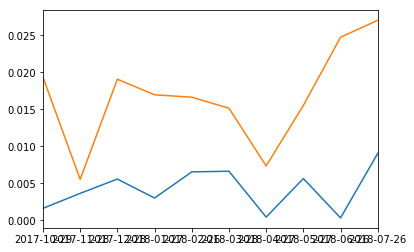

In [50]:
stock_ts['return'].plot()
stock_ts['risk'].plot()

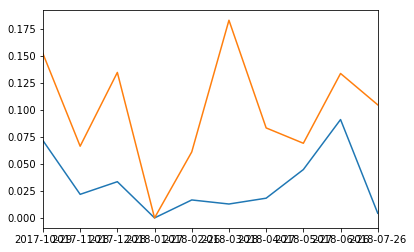

In [51]:
ccur_ts['return'].plot()
ccur_ts['risk'].plot()

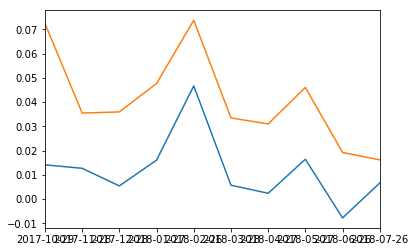

In [52]:
mixed_ts['return'].plot()
mixed_ts['risk'].plot()

In [95]:
# Calcular el VaR como medida interesante y mas fiable de los retornos
# Graficar el plot de las combinaciones de todos las combinaciones de las carteras

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [101]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    predicted_returns = pd.Series(predicted_returns)
    predicted_returns.index = simulation_outcomes.index
    real_returns = pd.Series(real_returns)
    real_returns.index = simulation_outcomes.index
    return std_error, predicted_returns, real_returns


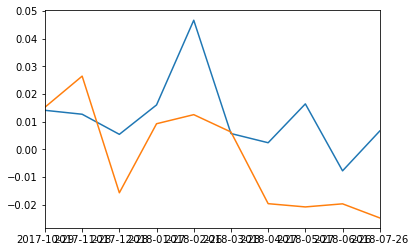

In [103]:
# Mixed
mix_std_error, mix_predicted_returns, mix_real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)
mix_predicted_returns.plot()
mix_real_returns.plot()

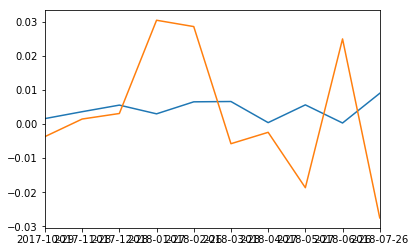

In [104]:
# stocks
stock_std_error, stock_predicted_returns, stock_real_returns = get_errors(stock_ts, percent_stocks_returns, pre_fixed_time_window)
stock_predicted_returns.plot()
stock_real_returns.plot()

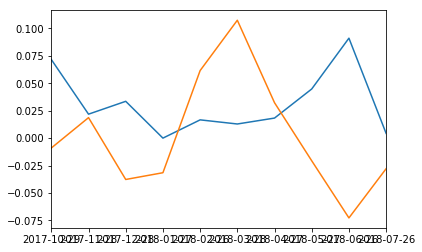

In [105]:
# Crypto
crypto_std_error, ccurr_predicted_returns, ccurr_real_returns = get_errors(ccur_ts, percent_cripto_returns, pre_fixed_time_window)
ccurr_predicted_returns.plot()
ccurr_real_returns.plot()

*** Summarized return in time: real vs predicted ***

Using the outcomes of the simulations, it is possible to measure the aggregated profit  

In [106]:
def get_aggregated_profit_in_percent(returns):  
    ammount = 100
    for rate in returns.values:
        ammount += np.multiply(ammount, rate)
    return np.subtract(ammount, 100)

In [107]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(stock_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(stock_real_returns)
print('Real aggregated profit using only stocks: ',aggregated_profit_r_return, "%")
print('Predicted aggregated profit using only stocks: ',aggregated_profit_p_return, '%')

Real aggregated profit using only stocks:  2.93570321118 %
Predicted aggregated profit using only stocks:  4.32751677183 %


In [108]:
# Crypto comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(ccurr_predicted_returns)
aggregated_monetary_r_return = get_aggregated_profit_in_percent(ccurr_real_returns)
print('Real aggregated profit (in percent) using only crypto: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using only crypto: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using only crypto:  2.93570321118 %
Predicted aggregated profit (in percent) using only crypto:  35.8806997733 %


In [109]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(mix_predicted_returns)
aggregated_monetary_r_return = get_aggregated_profit_in_percent(mix_real_returns)
print('Real aggregated profit (in percent) using mixed assets: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using mixed asset: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using mixed assets:  2.93570321118 %
Predicted aggregated profit (in percent) using mixed asset:  12.3852511453 %


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [546]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

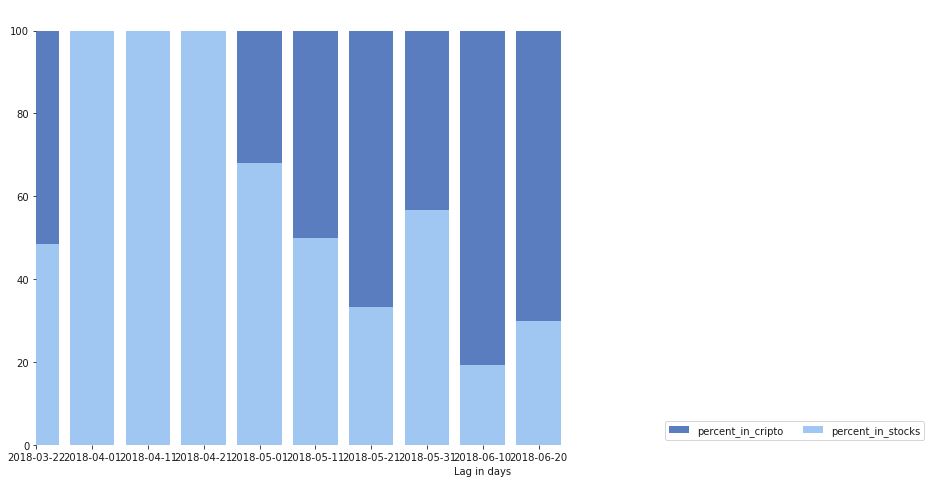

In [547]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Lag in days")
sns.despine(left=True, bottom=True)

In [634]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
150,0.012855,0.045616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032...",mixed_assets,-0.249399,3.230175,96.769825
120,0.049416,0.095202,"[0.0, 0.0, 0.109338355367, 0.0, 0.0, 0.1488134...",mixed_assets,-0.379809,28.252366,71.747634
90,0.004382,0.035520,"[0.135076513561, 0.135076513561, 0.0, 0.0, 0.0...",mixed_assets,-0.884798,72.984697,27.015303
60,0.004722,0.028266,"[0.335763435359, 0.0, 0.0, 0.280078517722, 0.0...",mixed_assets,-0.738469,61.584195,38.415805
30,0.012323,0.046801,"[0.204504213743, 0.0, 0.0, 0.0, 0.202093331283...",mixed_assets,-0.409423,40.659755,59.340245


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [X]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.